# Importing required libraries

In [33]:
import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
import torchtext
import torch.optim as optim
from nltk.corpus import stopwords 
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import string
import re
import functools
import sys

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Checking whether the device supports GPU Acceleration or not.
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
#Reading the IMDB-dataset
df = pd.read_csv('../input/imdb-datasetcsv/IMDB Dataset.csv')

In [4]:
df.head(), df.shape

(                                              review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
 (50000, 2))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Train, Test, Split

In [6]:
X, y = df['review'].values,df['sentiment'].values
x_train ,x_test, y_train, y_test = train_test_split(X,y,test_size = 0.1)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (45000,)
shape of test data is (5000,)


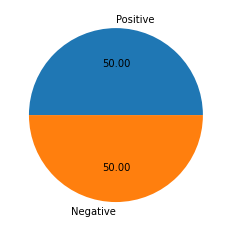

In [7]:
plt.pie(df['sentiment'].value_counts(), labels= ['Positive', 'Negative'], autopct = "%0.2f")
plt.show()

# Preprocessing the data

In [30]:
def preprocess_data(s):
    # Removing all non-word characters
    s = re.sub(r"[^\w\s]", '', s)
    # Replacing all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

#Tokenization
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_data(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dictionary
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_data(word)] for word in sent.lower().split() 
                                     if preprocess_data(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_data(word)] for word in sent.lower().split() 
                                    if preprocess_data(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [9]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
x_train, y_test

(array([list([548, 64, 185, 431, 52, 749, 18, 341, 93, 37, 954, 185, 14, 124, 100, 453, 123, 13, 5, 50, 110, 3]),
        list([54, 216, 206, 64, 402, 144, 638, 42, 798, 461, 270, 39, 295, 540, 346, 1, 12, 709, 320, 62, 812, 209, 894, 15, 55, 107, 55, 718, 201, 377, 658, 1, 333, 179, 662, 107, 981, 13, 11, 111, 873, 15, 703, 193, 55, 5, 1, 15, 4, 656, 798, 4, 714, 151, 67, 320, 873, 596, 62, 142, 353, 215, 918, 41, 231, 421, 62, 154, 44, 135, 431, 391, 7, 111, 764, 42, 295, 46, 297, 182]),
        list([2, 375, 2, 13, 45, 2, 247, 270, 198, 185, 39, 614, 68, 932, 787, 84, 526, 494, 28, 195, 397, 504, 222, 96, 111, 222, 51, 75, 769, 26, 29, 218, 212, 169, 101, 877, 207, 176, 481, 116, 59, 837, 135, 176, 52, 18, 40, 2, 54, 5, 107, 955]),
        ...,
        list([772, 53, 255, 332, 262, 655, 483, 109, 50, 772, 5, 14, 117, 81, 194, 600, 56, 153, 50, 478, 203, 80, 486, 787, 987, 525, 285, 27, 142, 75, 9, 171, 5, 130, 15, 194, 57, 800, 90, 156, 33, 19, 275, 508, 70, 57, 72, 25, 222, 96, 58,

# Adding padding

In [12]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [73]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test = DataLoader(x_test, batch_size=64,shuffle=False)
testy= DataLoader(y_test, batch_size=64,shuffle=False)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [14]:
#One batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 813, 352, 152],
        [  0,   0,   0,  ..., 394, 650, 118],
        [  0,   0,   0,  ..., 462, 699, 985],
        ...,
        [  0,   0,   0,  ...,  26, 218,   4],
        [  0,   0,   0,  ...,   9,  29, 186],
        [  0,   0,   0,  ..., 203, 426, 407]])
Sample input: 
 tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0])


# Model creation

In [58]:
class Sentiment_LSTM(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(Sentiment_LSTM,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [61]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = Sentiment_LSTM(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

Sentiment_LSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# Training¶


In [62]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [63]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.6514103213946024 val_loss : 0.6910899543762207
train_accuracy : 58.59111111111112 val_accuracy : 50.5
Validation loss decreased (inf --> 0.691090).  Saving model ...
Epoch 2
train_loss : 0.5058504961596595 val_loss : 0.340761009901762
train_accuracy : 73.24000000000001 val_accuracy : 85.8
Validation loss decreased (0.691090 --> 0.340761).  Saving model ...
Epoch 3
train_loss : 0.3367060657507843 val_loss : 0.3151220314204693
train_accuracy : 85.22888888888889 val_accuracy : 86.36
Validation loss decreased (0.340761 --> 0.315122).  Saving model ...
Epoch 4
train_loss : 0.324475867425402 val_loss : 0.3027518942952156
train_accuracy : 86.06 val_accuracy : 86.98
Validation loss decreased (0.315122 --> 0.302752).  Saving model ...
Epoch 5
train_loss : 0.2935090029488007 val_loss : 0.30934193909168245
train_accuracy : 87.5111111111111 val_accuracy : 86.82
Epoch 6
train_loss : 0.27570919872985944 val_loss : 0.3092486356943846
train_accuracy : 88.25333333333333 val_accur

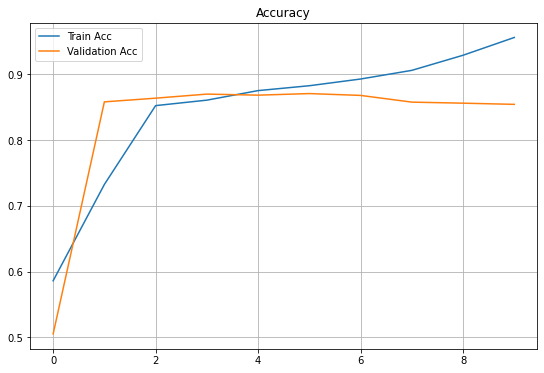

In [66]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    

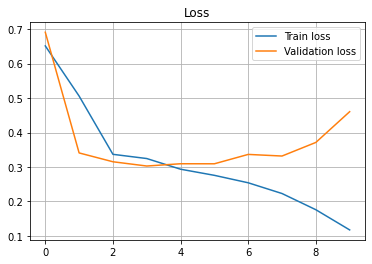

In [67]:
plt.subplot(1, 1, 1)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [68]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_data(word)] for word in text.split() 
                         if preprocess_data(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [70]:
index = 26
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

"The Cell" is an exotic masterpiece, a dizzying trip into not only the vast mind of a serial killer, but also into one of a very talented director. This is conclusive evidence of what can be achieved if human beings unleash their uninhibited imaginations. This is boldness at work, pushing aside thoughts to fall into formulas and cliches and creating something truly magnificent. This is the best movie of the year to date.<br /><br />I've read numerous complaints about this film, anywhere from all style and no substance to poorly cast characters and bad acting. To negatively criticize this film is to miss the point. This movie may be a landmark, a tradition where future movies will hopefully follow. "The Cell" has just opened the door to another world of imagination. So can we slam the door in its face and tell it and its director Tarsem Singh that we don't want any more? Personally, I would more than welcome another movie by Tarsem, and would love to see someone try to challenge him.<br

In [80]:
#Saving the Model
torch.save(model, "../working/state_dict.pt")